# Identifying Dogs vs Cats using TensorFlow Convolutional Neural Network
This nootbook creates a Convolutional Neural Network using TensorFlow to identify images of dogs and cats.

The images come from the Kaggle Dogs vs. Cats Dataset. https://www.kaggle.com/c/dogs-vs-cats

The creation of the neural network is based on the tutorials created by sentdex posted on his YouTube channel. However, the tutorial does a basic job of processing the data. The sizing of the image is very small, leading to some pixilation and loss of detail. The methods used to resize the images also create distortions in the image; to address this, boardering is used to fill in the image to create a uniform square.

In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
from matplotlib import pyplot as plt

TRAIN_DIR='/Users/alexvansteel/Projects/CIS365/TensorFlowImageRecognition/train/'
TEST_DIR='/Users/alexvansteel/Projects/CIS365/TensorFlowImageRecognition/test/'
IMG_SIZE=150
LR=1e-3

MODEL_NAME='dogsvscats-{}-{}.model'.format(LR,'2conv-basic') 

## Convert Images and Labels into Array Information

### Creating Labels
The images are labeled with "dog/cat"."number", so we need to split the labels into one-hot arrays as either a cat or a dog [cat,dog].

In [2]:
def label_img(img):
    word_label=img.split('.')[-3]
    #                       [much cat, no dog]
    if word_label=='cat': return [1,0]
    #                           [no cat, very doggo]
    elif word_label=='dog': return [0,1]

### Creating the Training Data
Here we will process all the data and place it into arrays for processing. The label name is processed with the above function. We then pull the images from the training directory and create the NumPy array of the images with their definitions. 

Here we will also work to resize the image. Rather than just resizing to blanket dimension which will create distortions, we will resize in a way to add padding to the image to prevent any distortions that may negatively affect the neural network.

We can also save it for later to speed up runs. We will also shuffle the data to improve the training by increasing variation.

In [3]:
def create_train_data():
    training_data=[]
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label=label_img(img)
        path=os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if (img.shape[0]>=img.shape[1]): # height is greater than width
            resizeto=(IMG_SIZE,int(round(IMG_SIZE*(float(img.shape[1])/img.shape[0]))));
        else:
            resizeto=(int(round(IMG_SIZE*(float(img.shape[0])/img.shape[1]))),IMG_SIZE);
        img=cv2.resize(img,(resizeto[1],resizeto[0]),interpolation=cv2.INTER_CUBIC)
        img=cv2.copyMakeBorder(img,0,IMG_SIZE-img.shape[0],0,IMG_SIZE-img.shape[1],cv2.BORDER_CONSTANT,0)
        training_data.append([np.array(img),np.array(label)])
        
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

### Create the Testing Data
Here we will do the same thing for the testing data. This test data has no label, so there is no need to process that.

In [15]:
def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path=os.path.join(TEST_DIR,img)
        img_num=img.split('.')[0]
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        if (img.shape[0]>=img.shape[1]): # height is greater than width
            resizeto=(IMG_SIZE,int(round(IMG_SIZE*(float(img.shape[1])/img.shape[0]))));
        else:
            resizeto=(int(round(IMG_SIZE*(float(img.shape[0])/img.shape[1]))),IMG_SIZE);
        img=cv2.resize(img,(resizeto[1],resizeto[0]),interpolation=cv2.INTER_CUBIC)
        img=cv2.copyMakeBorder(img,0,IMG_SIZE-img.shape[0],0,IMG_SIZE-img.shape[1],cv2.BORDER_CONSTANT,0)
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

This can be commented out based on if the data sets have already been preprocessed.

In [5]:
# train_data=create_train_data()
# If you have already created the dataset:
train_data=np.load('train_data.npy')

100%|██████████| 25000/25000 [01:22<00:00, 301.88it/s]


Let us see how a sample of the images look to check the boarders.

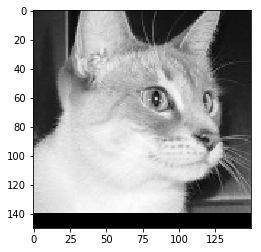

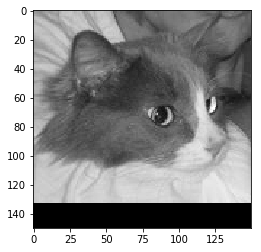

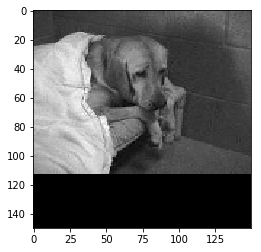

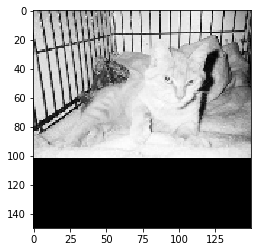

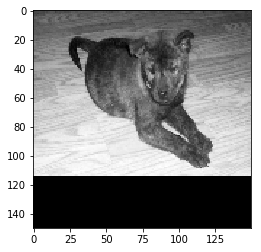

In [17]:
for i in range(5):
    data=train_data[i]
    plt.imshow(data[0],cmap='gray')
    plt.show()

## Splitting the Training Data
Here we will split the training data into training and testing data sets for teaching the neural network. We will used the labeled training data to train the network, and then the labeled testing data to validate our network.

In [7]:
train=train_data[:-500]
test=train_data[-500:]

Here we separate the features and data.

In [8]:
X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]

test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

# TensorFlow
Now we can use the TensorFlow library to build a Convolutional Neural Network and train it to recognise if an image contains a cat or a dog. 

In [9]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet=input_data(shape=[None,IMG_SIZE,IMG_SIZE,1],name='input')

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,32,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=conv_2d(convnet,64,5,activation='relu')
convnet=max_pool_2d(convnet,5)

convnet=fully_connected(convnet,1024,activation='relu')
convnet=dropout(convnet,0.8)

convnet=fully_connected(convnet,2,activation='softmax')
convnet=regression(convnet,optimizer='adam',learning_rate=LR,loss='categorical_crossentropy',name='targets')

model=tflearn.DNN(convnet,tensorboard_dir='log')

### Saving or Reloading the Model
This will either save or reload the model after every session if we want to retrain our network.

In [10]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

## Create the Arrays
Here we will first create the training and testing data from the director with the training images. We will use the training data to teach the neural network, and then the testing data that we saved to validate our network.

In [11]:
train=train_data[:-500]
test=train_data[-500:]

# Training Time
And now we will separate our labels and features from our testing data so we can use it to verify our networks capabilities.

We then fir the training data to the model and test it to see what the accuracy is over 10 epochs. Too few epochs will create an undertrained model. Too many will create an overtrained one. 

In [12]:
X=np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y=[i[1] for i in train]

test_x=np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y=[i[1] for i in test]

model.fit({'input':X},{'targets':Y},n_epoch=10,validation_set=({'input':test_x},{'targets':test_y}),
          snapshot_step=500,show_metric=True,run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.19467 | time: 1103.401s
| Adam | epoch: 010 | loss: 0.19467 - acc: 0.9162 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.18626 | time: 1114.935s
| Adam | epoch: 010 | loss: 0.18626 - acc: 0.9199 | val_loss: 0.34241 - val_acc: 0.8540 -- iter: 24500/24500
--


So over the course of 10 epochs of training with images resized to 150x150 pixles on a brand new network, we end up with an accuracy of 91.99% on our training data and 85.40% on our testing data.

### Save the Model

In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/alexvansteel/Projects/CIS365/TensorFlowImageRecognition/dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


# Testing the Model
Now that we have a model that is able to identify if an image contains a dog or a cat with more accuracy than a coin flip, let us see how it compares to some unlabled testing data. 

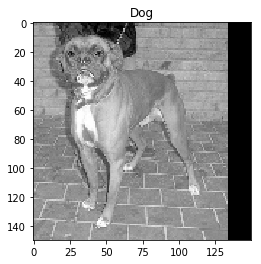

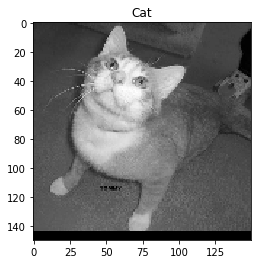

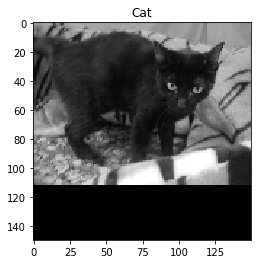

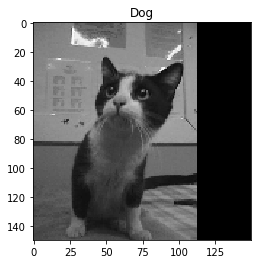

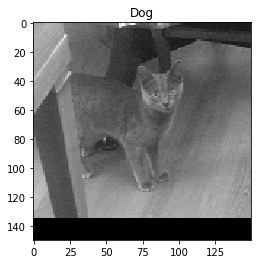

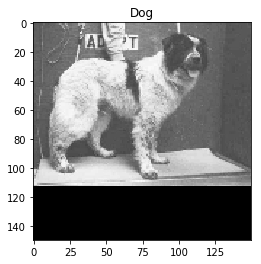

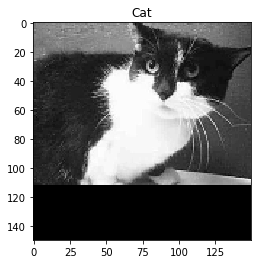

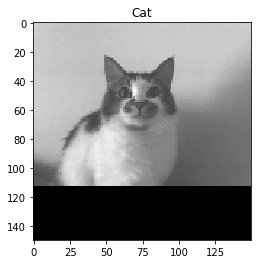

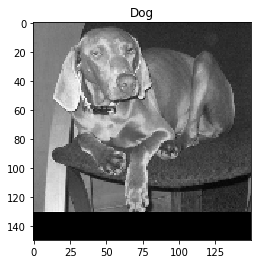

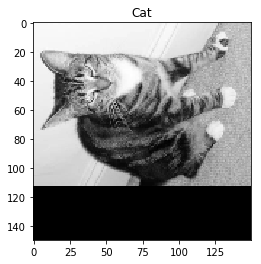

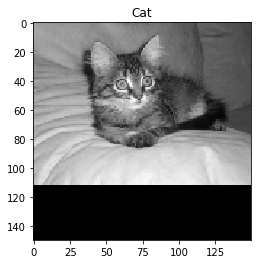

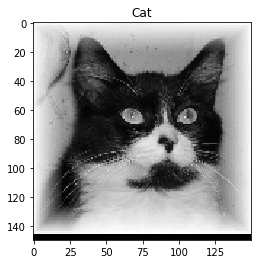

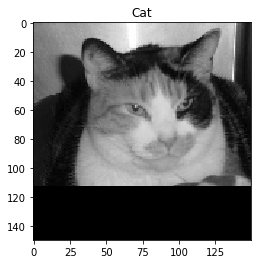

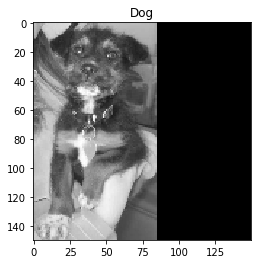

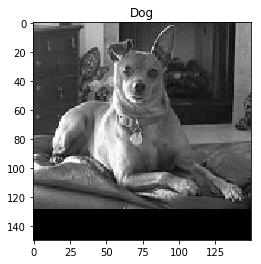

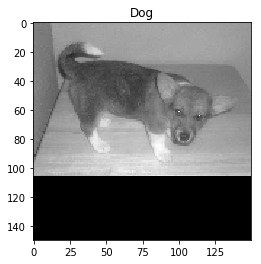

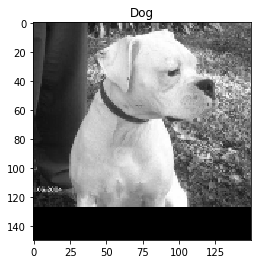

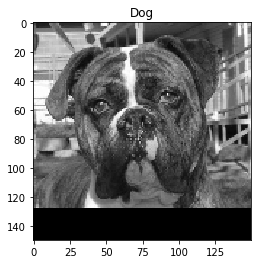

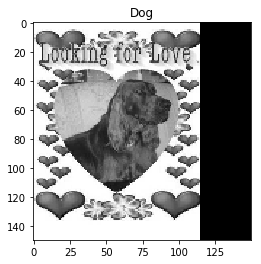

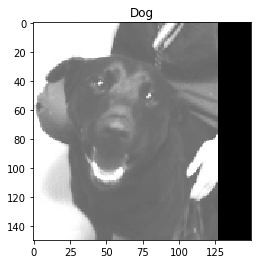

In [19]:
# if you need to create the data:
# test_data=process_test_data()
# if you already have some saved:
test_data=np.load('test_data.npy')

# fig=plt.figure()

for num,data in enumerate(test_data[:20]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num=data[1]
    img_data=data[0]
    
#     y=fig.add_subplot(3,7,num+1)
    orig=img_data
    data=img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out=model.predict([data])[0]
    
    if np.argmax(model_out)==1: str_label='Dog'
    else: str_label='Cat'
        
    plt.imshow(orig,cmap='gray')
    plt.title(str_label)
#     plt.axes.get_xaxis().set_visible(False)
#     plt.axes.get_yaxis().set_visible(False)
    plt.show()